In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

In [2]:
img = cv2.imread('set/cards/card226_b_1_f_o.jpg')
wb = cv2.xphoto.createGrayworldWB()
balanced_img = wb.balanceWhite(img)
cv2.imshow('Original Image', img)
cv2.imshow('Balanced Image', balanced_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
def detect_color(src):
    # Extract the channels
    blue_channel = src[:,:,0]
    green_channel = src[:,:,1]
    red_channel = src[:,:,2]

    center_column_index = blue_channel.shape[1] // 2

    blue_column = blue_channel[150:350, center_column_index]
    green_column = green_channel[150:350, center_column_index]
    red_column = red_channel[150:350, center_column_index]

    plt.figure()
    plt.plot(blue_column, "blue")
    plt.plot(green_column, "green")
    plt.plot(red_column, "red")
    
    blue_sum = sum(blue_column)
    green_sum = sum(green_column)
    red_sum = sum(red_column)

    print(f"blue_sum: {blue_sum}")
    print(f"green_sum: {green_sum}")
    print(f"red_sum: {red_sum}")

In [218]:
def detect_amount(src):
    blurred_image = cv2.GaussianBlur(src, (25,25), 3)

    center_column_index = blurred_image.shape[1] // 2
    center_column = blurred_image[:, center_column_index]

    avg = np.average(center_column)

    plt.imshow(blurred_image, cmap='gray')

    plt.figure()
    plt.plot(center_column)
    plt.hlines(avg- 7, 0, 499, colors='k', linestyles='solid')

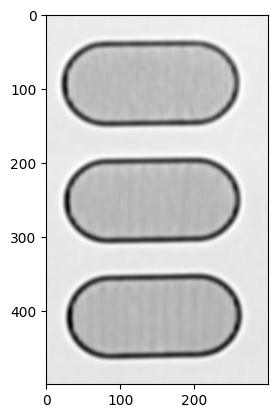

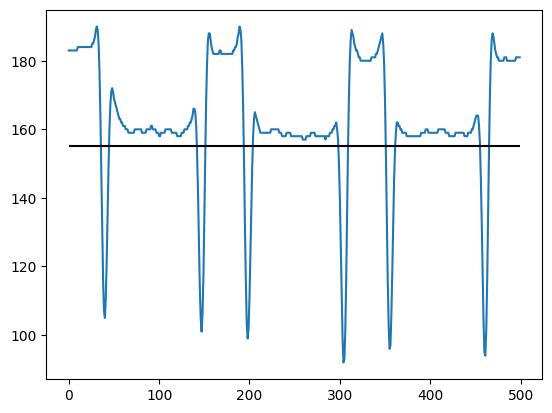

In [221]:
# Read the color image as a grayscale image
gray_image = cv2.imread("set/cards/card168_b_3_s_o.jpg", cv2.IMREAD_GRAYSCALE)

detect_amount(gray_image)

blue_sum: 23933
green_sum: 30283
red_sum: 16153


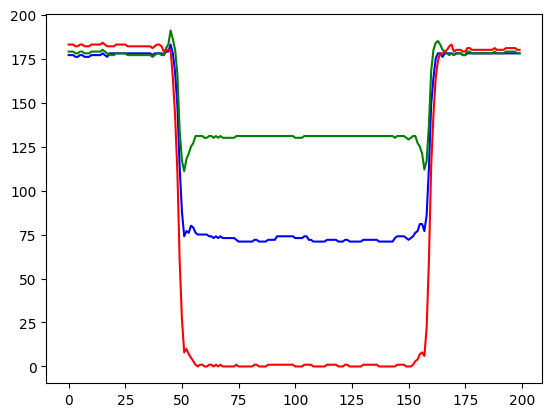

In [28]:
# Read the color image
img = cv2.imread('set/cards/card17_g_1_f_o.jpg')

# apply white balance
wb = cv2.xphoto.createGrayworldWB()
balanced_img = wb.balanceWhite(img)

detect_color(balanced_img)